In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True); sns.set(); sns.set_context(rc={'lines.markeredgewidth': 1})

## How biased is global NWP model output?
Let's start by reading in the nwp data as well as obs from SeaTac airport and the GFS 0.5deg nearest boundary box. The observations will need to be resampled to the end of the hour so that the datetimes align to that of the NWP output. After that, we can join both dataframes on time index and evaluate forecast performance.

In [2]:
# reading data from file
nwp = pd.DataFrame.from_csv('./merged_gfs.csv', index_col='time')
obs = pd.DataFrame.from_csv('./seatac_weather.csv')

# converting timestring into a python datetime object
obs['time'] = obs.apply(lambda x: x['Date'] + ' ' + x['Time'], axis=1)
obs['time'] = obs['time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))

# dropping unecessary observation columns columns
obs.index = obs.time
obs.drop(['Date', 'time', 'Time'], inplace=True, axis=1)

obs.head(5)

,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure
time,,,,,,,
2015-01-01 00:53:00,33,20,58.4,6,M,10,1033.8
2015-01-01 01:53:00,34,22,61.0,10,M,30,1033.4
2015-01-01 02:53:00,34,21,58.5,11,M,30,1032.9
2015-01-01 03:53:00,33,22,63.5,9,M,30,1032.8
2015-01-01 04:53:00,32,22,66.2,8,M,30,1032.2


In [3]:
# resample to alight to end of hour
obs = obs.resample(dt.timedelta(hours=1), how='mean', label='right')
obs.head(5)

,Temperature,Dewpoint,Relhum,Speed
time,,,,
2015-01-01 01:00:00,33,20,58.4,6
2015-01-01 02:00:00,34,22,61.0,10
2015-01-01 03:00:00,34,21,58.5,11
2015-01-01 04:00:00,33,22,63.5,9
2015-01-01 05:00:00,32,22,66.2,8


In [4]:
nwp.head(3)

,dew_height:2_lat:47.5_lon:237.5,dew_height:2_lat:47.5_lon:238.0,pres_height:80_lat:47.5_lon:237.5,pres_height:80_lat:47.5_lon:238.0,hum_height:1000_lat:47.5_lon:237.5,hum_height:1000_lat:47.5_lon:238.0,hum_height:5000_lat:47.5_lon:237.5,hum_height:5000_lat:47.5_lon:238.0,hum_height:10000_lat:47.5_lon:237.5,hum_height:10000_lat:47.5_lon:238.0,...,temp_height:80_lat:47.5_lon:237.5,temp_height:80_lat:47.5_lon:238.0,temp_height:100_lat:47.5_lon:237.5,temp_height:100_lat:47.5_lon:238.0,ws_height:10_lat:47.5_lon:237.5,ws_height:10_lat:47.5_lon:238.0,ws_height:80_lat:47.5_lon:237.5,ws_height:80_lat:47.5_lon:238.0,ws_height:100_lat:47.5_lon:237.5,ws_height:100_lat:47.5_lon:238.0
time,,,,,,,,,,,,,,,,,,,,,
2015-02-02 00:00:00,43.160023,42.619987,100200.898438,98165.703125,1.05,1.09,2.1,2.2,2.9,2.9,...,43.880013,44.780010,43.519989,44.599998,6.458986,1.724906,9.040796,4.010000,9.410723,4.447752
2015-02-02 03:00:00,42.980011,42.799999,100264.421875,98264.421875,0.96,1.00,2.0,2.1,2.8,2.8,...,43.160023,43.519989,42.980011,43.339977,4.663143,1.906463,6.790943,4.348839,7.178092,4.774474
2015-02-02 06:00:00,43.447975,43.789978,100353.750000,98336.148438,0.86,0.90,2.0,2.0,2.2,2.1,...,43.700001,44.780010,43.519989,44.599998,3.432098,1.824856,4.849918,4.124379,5.155289,4.492182


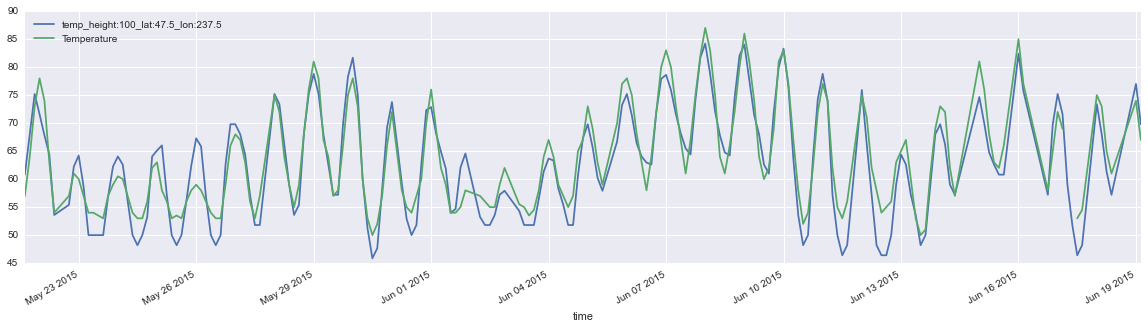

In [5]:
# join nwp and observation on datetime
df = nwp.join(obs)

# specifying the target variable
target = 'Temperature'
nwp_feature = 'temp_height:100_lat:47.5_lon:237.5'

# plot a timeseries of temperature from model and obs 
df[[nwp_feature, target]][700:900].plot(figsize=(20,5))

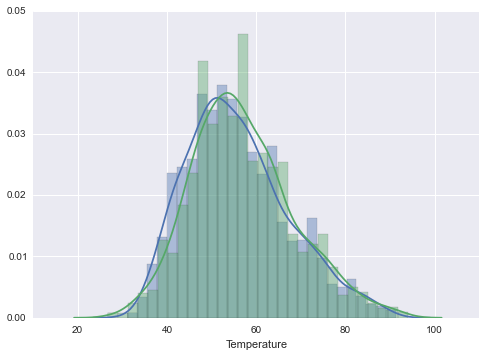

In [6]:
# create a month variable to facet by month and dropping NA's
df['month'] = df.index.month
df = df.dropna()

# plotting the distribution of 2 variables using seaborn
sns.distplot(df[nwp_feature])
sns.distplot(df[target])

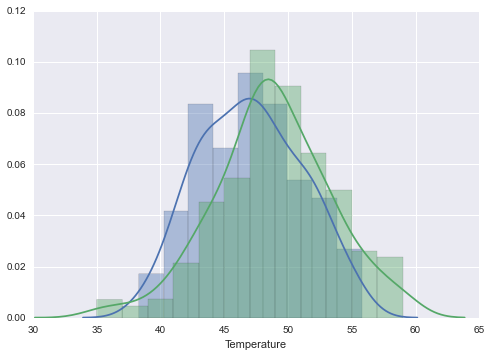

In [7]:
# plotting for a specific month
sns.distplot(df[nwp_feature][df['month']==2])
sns.distplot(df[target][df['month']==2])

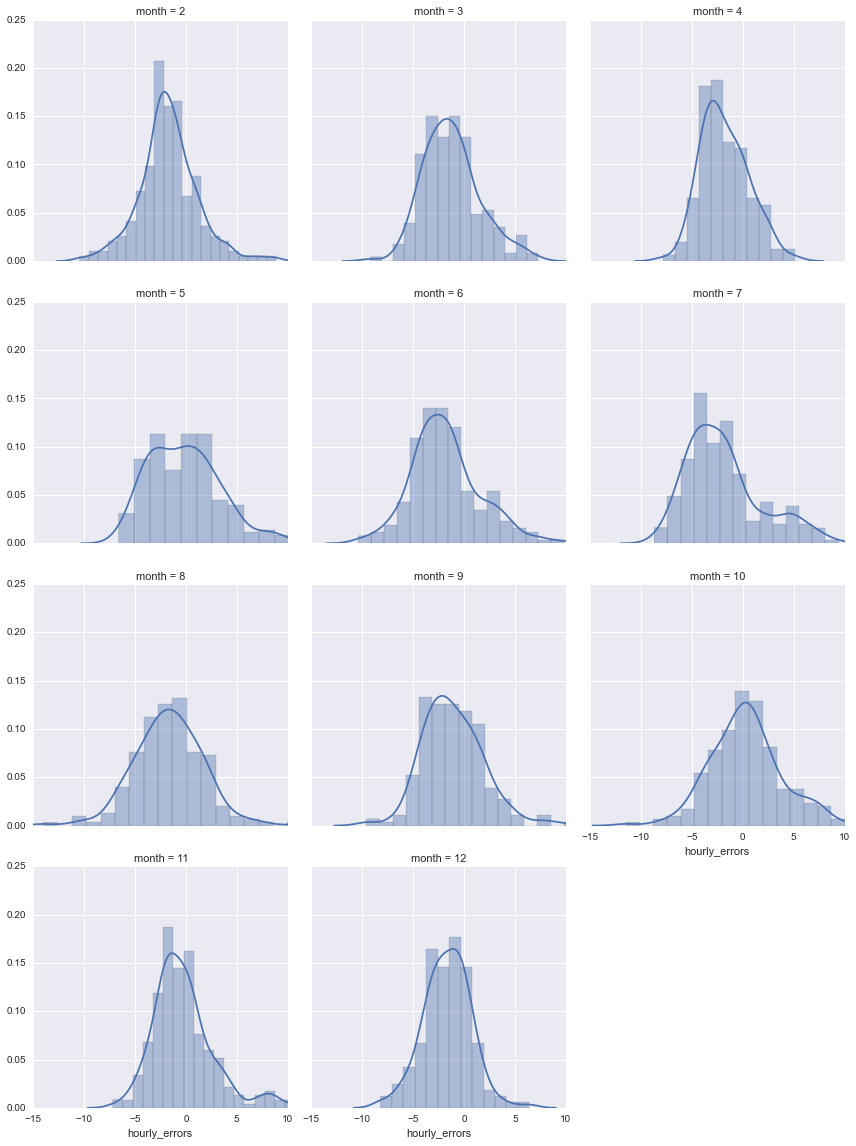

In [8]:
# computing errors and faceting errors by month
errs = pd.DataFrame()
errs['hourly_errors'] = df[nwp_feature] - df[target]
errs['month'] = df['month']

g = sns.FacetGrid(errs, col="month", col_wrap=3, size=4, xlim=(-15,10))
g.map(sns.distplot, "hourly_errors");

## Model Output Statistics Using Scikit-learn
Let's start by building a simple model to try and correct for these errors. One way to do so is to model observation as a function of model output. This model will be able to capture some of the biases that appear in the model. For those interested, the original paper is "The Use of Model Output Statistics (MOS) in Objective Weather Forecasting" by Harry R. Glahn and Dale A. Lowry.

To validate performance, we need to split our dataset into training and testing samples. Given the short length of this dataset, I will create a testing set from every 4th week of the dataset, while the remainder will be used for training.

In [9]:
from sklearn.linear_model import LinearRegression

# a method to split data into testing and training set every k-weeks
def split_dataframe(df, target, k=4):
    df['weekOfYear'] = df.index.weekofyear
    df_trn = df[df['weekOfYear']%k!=0]
    df_tst = df[df['weekOfYear']%4==0]

    drop_vars = ['Temperature', 'Dewpoint', 'Relhum', 'Speed', 'month', 'weekOfYear']
    if target not in drop_vars:
        drop_vars.append(target)
        
    xtrn, ytrn = df_trn.drop(drop_vars, axis=1), df_trn[target]
    xtst, ytst = df_tst.drop(drop_vars, axis=1), df_tst[target]
    
    return xtrn, ytrn, xtst, ytst

In [10]:
xtrn, ytrn, xtst, ytst = split_dataframe(df, target, k=4)
# set normalize to True since linear models are sensitive to scale
linear_model_mos = LinearRegression(normalize=True)
# fit data on training set
linear_model_mos.fit(xtrn, ytrn)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [11]:
# look at model coefficients 
linear_model_mos.coef_

array([ -5.94056154e-03,   7.29150399e-02,  -1.71296852e-02,
         1.78933953e-02,   6.35407003e+00,  -7.37360360e+00,
         1.02617367e+00,  -1.77764431e+00,  -2.49795873e-01,
         1.25266857e-01,   1.66259787e+00,  -3.55507267e-01,
        -5.69665231e+00,   2.42656518e+00,   4.35399386e+00,
        -2.21307517e+00,   1.05907642e+00,  -1.93244889e+00,
        -6.52354998e+00,   7.77158112e+00,   5.57611355e+00,
        -6.65024728e+00,   1.47299877e-01,   8.71087432e-02,
         4.36004188e-01,   5.48739934e-01,   6.71434587e-02,
        -4.14856929e-01,  -5.41370429e-01,   7.42868222e-01,
        -5.82563332e-01,  -4.55117834e+00,   1.04385332e+00,
         3.92776992e+00])

In [12]:
# predict on testing set
ymos = linear_model_mos.predict(xtst)

### Verification: Evaluating our Model
Depending on the industry, we might evaluate our model differently. The energy sector roughly cares about overall error, but as well as identifying large changes of wind energy over short periods of time. The roads sector cares less about overall loss (mae, rmse), but only about loss when temperature is near freezing. For the sake of simplicity, I will proceed with evaluating the distribution of errors as well as bias and rmse 

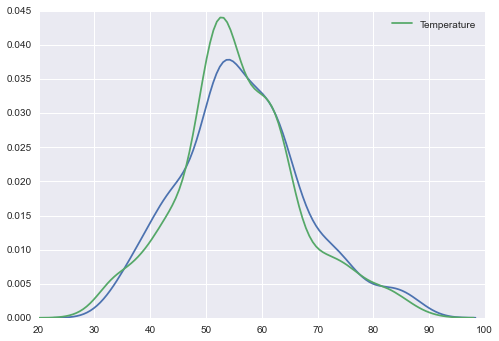

In [13]:
sns.kdeplot(ymos)
sns.kdeplot(ytst)

In [14]:
error_mos = ymos-ytst
error_raw = xtst[nwp_feature]-ytst

print "model output bias is %.2f while mos bias is %.2f" % (np.mean(error_raw), np.mean(error_mos))
print "model output rmse is %.2f while mos rmse is %.2f" % (np.mean(error_raw**2)**0.5, np.mean(error_mos**2)**0.5)

model output bias is -0.68 while mos bias is 0.71
model output rmse is 3.53 while mos rmse is 2.87


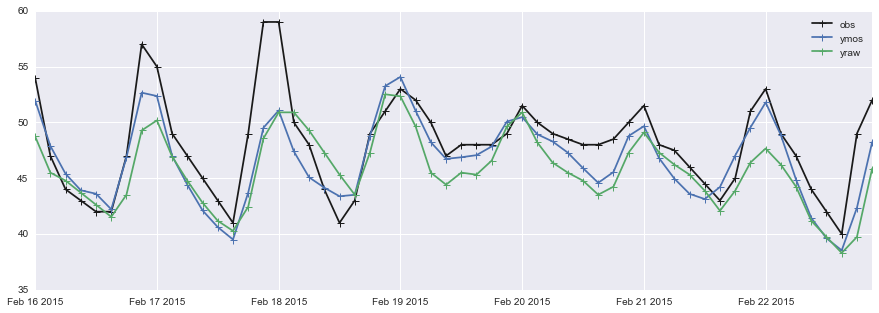

In [15]:
df_verif = pd.DataFrame()
df_verif['obs'] = ytst
df_verif['ymos'] = ymos
df_verif['yraw'] = xtst[nwp_feature]

idx = df_verif.index <= dt.datetime(2015,2,23)
plt.figure(figsize=(15,5))
plt.plot(df_verif.index[idx], df_verif['obs'][idx], color='k', marker='+')
plt.plot(df_verif.index[idx], df_verif['ymos'][idx], color='b', marker='+')
plt.plot(df_verif.index[idx], df_verif['yraw'][idx], color='g', marker='+')
plt.legend(['obs', 'ymos', 'yraw'])

### Nonlinear MOS

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
nonlinear_model_mos = GradientBoostingRegressor()
nonlinear_model_mos.fit(xtrn, ytrn)

nonlinear_model_mos

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [19]:
print nonlinear_model_mos.estimators_
tree_id1 = nonlinear_model_mos.estimators_[34][0]

[[ DecisionTreeRegressor(criterion=<sklearn.tree._tree.FriedmanMSE object at 0x1117af540>,
           max_depth=3, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           random_state=<mtrand.RandomState object at 0x10afbfb90>,
           splitter=<sklearn.tree._tree.PresortBestSplitter object at 0x1112207c0>)]
 [ DecisionTreeRegressor(criterion=<sklearn.tree._tree.FriedmanMSE object at 0x1117af540>,
           max_depth=3, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           random_state=<mtrand.RandomState object at 0x10afbfb90>,
           splitter=<sklearn.tree._tree.PresortBestSplitter object at 0x1112207c0>)]
 [ DecisionTreeRegressor(criterion=<sklearn.tree._tree.FriedmanMSE object at 0x1117af540>,
           max_depth=3, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_

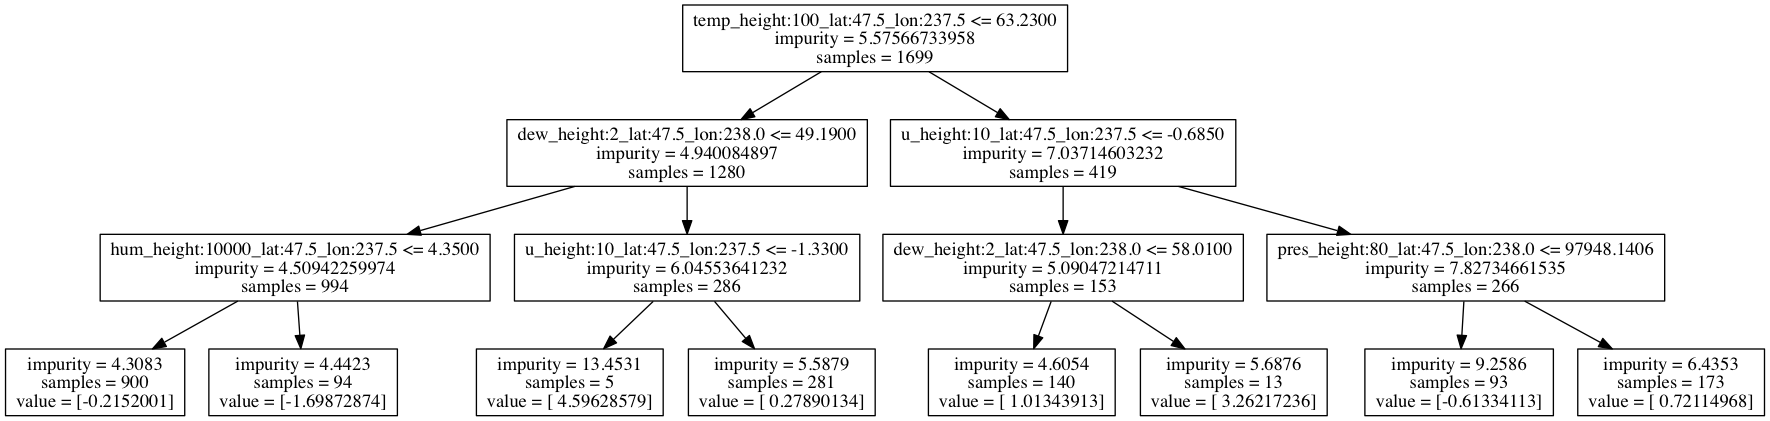

In [20]:
from sklearn.tree import export_graphviz
from IPython.display import Image

with open('tree_1.dot', 'w') as dotfile:
     export_graphviz(tree_id1,
                     dotfile,
                     feature_names=xtrn.columns)

!dot -Tpng tree_1.dot -o tree.png
Image(filename='tree.png') 

In [22]:
idx_feature_importance = np.argsort(-nonlinear_model_mos.feature_importances_)
print xtrn.columns[idx_feature_importance][:10]

Index([u'temp_height:2_lat:47.5_lon:237.5',
       u'temp_height:80_lat:47.5_lon:237.5',
       u'dew_height:2_lat:47.5_lon:238.0',
       u'hum_height:10000_lat:47.5_lon:237.5',
       u'temp_height:80_lat:47.5_lon:238.0',
       u'temp_height:2_lat:47.5_lon:238.0',
       u'temp_height:100_lat:47.5_lon:237.5',
       u'u_height:100_lat:47.5_lon:238.0',
       u'hum_height:10000_lat:47.5_lon:238.0',
       u'dew_height:2_lat:47.5_lon:237.5'],
      dtype='object')


In [23]:
ymos_nonlinear = nonlinear_model_mos.predict(xtst)

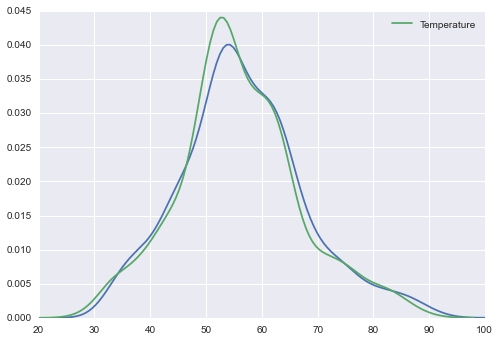

In [24]:
sns.kdeplot(ymos_nonlinear)
sns.kdeplot(ytst)

In [25]:
error_mos_nonlinear = ymos_nonlinear-ytst

print "nonlinear mos bias is %.2f while mos bias is %.2f" % (np.mean(error_mos_nonlinear), np.mean(error_mos))
print "nonlinear mos rmse is %.2f while mos rmse is %.2f" % (np.mean(error_mos_nonlinear**2)**0.5, np.mean(error_mos**2)**0.5)

nonlinear mos bias is 0.63 while mos bias is 0.71
nonlinear mos rmse is 2.76 while mos rmse is 2.87


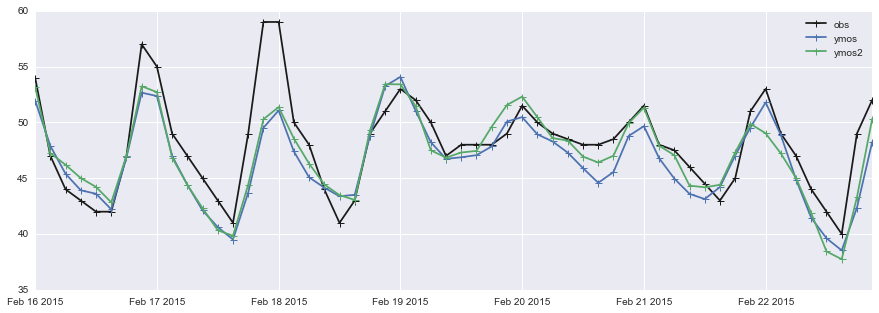

In [26]:
df_verif['ymos2'] = ymos_nonlinear

plt.figure(figsize=(15,5))
plt.plot(df_verif.index[idx], df_verif['obs'][idx], color='k', marker='+')
plt.plot(df_verif.index[idx], df_verif['ymos'][idx], color='b', marker='+')
plt.plot(df_verif.index[idx], df_verif['ymos2'][idx], color='g', marker='+')
plt.legend(['obs', 'ymos', 'ymos2'])

### Analogues (... K-Nearest Neighbors)

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn_model_mos = KNeighborsRegressor(n_neighbors=5)
knn_model_mos.fit(xtrn, ytrn)

ymos_knn = knn_model_mos.predict(xtst)

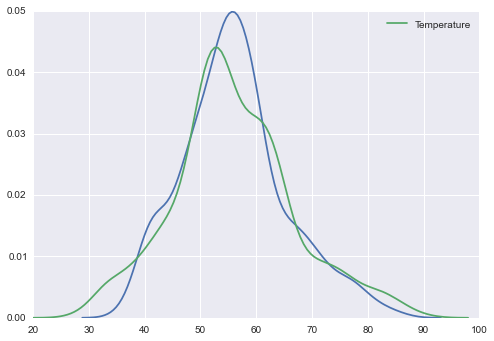

In [28]:
sns.kdeplot(ymos_knn)
sns.kdeplot(ytst)

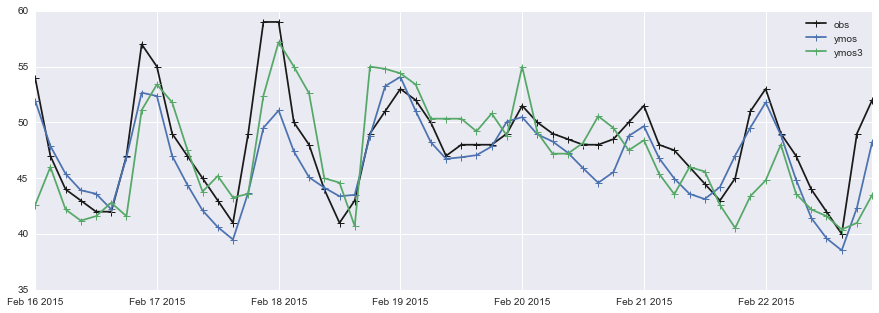

In [29]:
df_verif['ymos3'] = ymos_knn

plt.figure(figsize=(15,5))
plt.plot(df_verif.index[idx], df_verif['obs'][idx], color='k', marker='+')
plt.plot(df_verif.index[idx], df_verif['ymos'][idx], color='b', marker='+')
plt.plot(df_verif.index[idx], df_verif['ymos3'][idx], color='g', marker='+')
plt.legend(['obs', 'ymos', 'ymos3'])

### Unconventional MOS: is there going to be icing tomorrow?
As mentioned above, we often care about events happening and not about a continuous variable we observe. In roads, being able to predict if there will be risk of icing is more important than the actual temperature forecast. To do that, we may need to cast some variables as categorical variables representing an even taking place or not.

In [32]:
df['freeze'] = 0
df['freeze'][df['Temperature'] < 40] = 1

df['freeze'].describe()

/Users/charlie/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


count    2257.000000
mean        0.046522
std         0.210659
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: freeze, dtype: float64

In [33]:
from sklearn.ensemble import RandomForestClassifier
target = 'freeze'

xtrn, ytrn, xtst, ytst = split_dataframe(df, target, k=4)
model_icing = RandomForestClassifier(class_weight='auto')
model_icing.fit(xtrn,ytrn)

is_icing = model_icing.predict(xtst)

In [34]:
df_confusion = pd.crosstab(ytst, is_icing, rownames=['Actual'], colnames=['Predicted'], margins=True)
print df_confusion

Predicted    0   1  All
Actual                 
0          519   1  520
1           21  17   38
All        540  18  558


In [35]:
df_verif['is_icing_cont'] = 0
df_verif['is_icing_cont'][df_verif['yraw'] < 40] = 1

df_confusion = pd.crosstab(ytst, df_verif['is_icing_cont'], rownames=['Actual'], colnames=['Predicted'], margins=True)
print df_confusion

Predicted    0   1  All
Actual                 
0          509  11  520
1            5  33   38
All        514  44  558


/Users/charlie/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


### Clustering, Dimension Reduction, and Beyond
...

## Extensions to more complex (and real) applications
 **Hyperparameter tuning to improve model accuracy**: I used default parameters here for boosted trees, this may not be optimal. One could be more careful about tuning parameters for better performance
 
 **Risks of overfitting/underfitting**
 
 **Feature selection and feature engineering**: this is the key to better machine learning. In this (very) contrived example I used only a few features from one model using 2 grid points. One could increase the feature space and improve performance, however extra care would need to be taken to ensure no overfitting.
 
 **Multiple init times and weather scenarios**: many industries rely on forecasts to represent actual weather scenarios. I have forecasted every hour here independent of the hours surrounding it. This is sub-optimal and could be vastly improved.
 
 **Generating probabalistic forecasts**: use quantile loss function or bootstrap errors. I could generate prediction intervals easily by choosing a quantile loss function within scikitlearn. These will be uncalibrated and unreliable! Time series errors will cause prediction intervals to be overconfident since errors are correlated but model assumes they are independent  
 
 **Handling multiple NWP models and model ensembles**: the number of models and ensembles are huge: ECMWF (51 members), GEFS (21 members), NAM, HRRR, local WRF ensembles, etc...  Once training longer time-series and with more features, with all these models, you will run into memory problems. Many routes one could take here including pyspark, mrjob, graphlab create, etc...